In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
train_data=np.genfromtxt('../week_2/MNIST/mnist_train.csv',delimiter=',')
test_data=np.genfromtxt('../week_2/MNIST/mnist_test.csv',delimiter=',')

In [3]:
train_labels=train_data[:,0]
train_set=train_data[:,1:]
test_labels=test_data[:,0]
test_set=test_data[:,1:]

In [4]:
print(np.shape(train_set))
print(np.shape(test_set))

(60000, 784)
(10000, 784)


In [5]:
enc=preprocessing.OneHotEncoder(sparse=False,categories='auto')

In [6]:
enc.fit(train_labels.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [7]:
train_labels_onehot=enc.transform(train_labels.reshape(-1,1))
test_labels_onehot=enc.transform(test_labels.reshape(-1,1))

In [8]:
train_labels_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [9]:
test_labels_onehot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
train_set = train_set.reshape(60000,28,28,1)
test_set = test_set.reshape(10000,28,28,1)

In [35]:
class MNIST_CNN:
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='input')
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        
        # For batch norm and dropout
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.conv2d(self.input, 28, (11, 11), strides=(4, 4), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv1')
            print(h)
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 56, (5, 5), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv2')
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 56, (3, 3), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv3')
            
            # Downsample
            h = tf.layers.max_pooling2d(h, (2, 2), (2, 2), padding='valid', name='pool1')
            print(h)
            
            # Fully connected layers
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.flatten(h)
            print(h)
            
            h = tf.layers.dense(h, 28, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.nn.relu, name='dense1')
            print(h)
            h = tf.layers.dropout(h, rate=0.25, training=self.is_training, name='dropout1')
            print(h)
            
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='dense2')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            self.precision = tf.reduce_mean(self.prediction*self.ground_truth)

        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        print('Start Training')
        losses = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            for i in range(iteration_steps):
                samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
                
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: True}
                _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                
                if i % 50 == 0:
                    print("Minibatch loss at step {}: {}".format(i, loss))
                    losses.append([i, loss])
                    
            saver.save(sess, './model')
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        self.test_pointer = 0
        end_of_epoch = False
        losses = []
        precisions = []
        
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph("./model.meta")
            saver.restore(sess, './model')
            while not end_of_epoch:
                samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: False}
                losses.append(sess.run(self.loss, feed_dict=feed_dict))
                precisions.append(sess.run(self.precision, feed_dict=feed_dict))
        print("Average test loss: {}".format(np.mean(losses)))
        print("Average test precision: {}".format(np.mean(precisions)))

In [37]:
tf.reset_default_graph()
WD_FACTOR = 0.0
LEARNING_RATE = 0.001
model = MNIST_CNN(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("layers/conv1/BiasAdd:0", shape=(?, 7, 7, 28), dtype=float32)
Tensor("layers/pool1/MaxPool:0", shape=(?, 3, 3, 56), dtype=float32)
Tensor("layers/flatten/Reshape:0", shape=(?, 504), dtype=float32)
Tensor("layers/dense1/Relu:0", shape=(?, 28), dtype=float32)
Tensor("layers/dropout1/cond/Merge:0", shape=(?, 28), dtype=float32)
Tensor("layers/dense2/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_4:0", shape=(), dtype=float32)


In [38]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set, train_labels_onehot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.626481056213379
Minibatch loss at step 50: 0.4495670199394226
Minibatch loss at step 100: 0.22456824779510498
Minibatch loss at step 150: 0.22280184924602509
Minibatch loss at step 200: 0.14424251019954681
Minibatch loss at step 250: 0.1786392778158188
Minibatch loss at step 300: 0.10426922142505646
Minibatch loss at step 350: 0.16647326946258545
Minibatch loss at step 400: 0.17550642788410187
Minibatch loss at step 450: 0.14934603869915009
Minibatch loss at step 500: 0.06552302837371826
Minibatch loss at step 550: 0.05068168789148331
Minibatch loss at step 600: 0.05771771818399429
Minibatch loss at step 650: 0.07061652094125748
Minibatch loss at step 700: 0.09996373951435089
Minibatch loss at step 750: 0.10561545193195343
Minibatch loss at step 800: 0.09133583307266235
Minibatch loss at step 850: 0.03967747837305069
Minibatch loss at step 900: 0.1409357786178589
Minibatch loss at step 950: 0.1353156864643097
Minibatch loss at step 1000: 0.052

Minibatch loss at step 8300: 0.00829398538917303
Minibatch loss at step 8350: 0.011044622398912907
Minibatch loss at step 8400: 0.0018712211167439818
Minibatch loss at step 8450: 0.022888660430908203
Minibatch loss at step 8500: 0.007007864769548178
Minibatch loss at step 8550: 0.012913266196846962
Minibatch loss at step 8600: 0.04425138980150223
Minibatch loss at step 8650: 0.017760509625077248
Minibatch loss at step 8700: 0.0005477896775119007
Minibatch loss at step 8750: 0.008988309651613235
Minibatch loss at step 8800: 0.03547430783510208
Minibatch loss at step 8850: 0.011317454278469086
Minibatch loss at step 8900: 0.0024641507770866156
Minibatch loss at step 8950: 0.00928648840636015
Minibatch loss at step 9000: 0.0006924492190591991
Minibatch loss at step 9050: 0.0077907619997859
Minibatch loss at step 9100: 0.0017951929476112127
Minibatch loss at step 9150: 0.007771703880280256
Minibatch loss at step 9200: 0.004882729146629572
Minibatch loss at step 9250: 0.003383169649168849
M

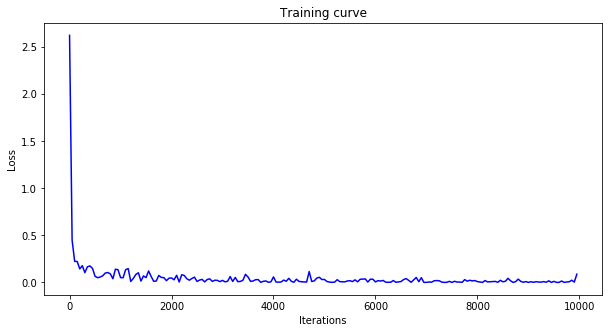

In [39]:
import matplotlib.pyplot as plt
losses=np.array(losses)
iterations = losses[:, 0]
train_loss = losses[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [41]:
TEST_BATCH_SIZE = 128

model.test(train_set, train_labels_onehot, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 0.007404327392578125
Average test loss: 0.09966221451759338


In [40]:
TEST_BATCH_SIZE = 128

model.test(test_set, test_labels_onehot, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 0.06277027726173401
Average test loss: 0.09861195832490921
